In [67]:
import torch
import torchvision
import numpy as np
from matplotlib import pyplot
import h5py
from torch_geometric.data import Dataset, Data

In [68]:
DATA_SIZE=800
LR=0.01
BATCH_SIZE=32
HIDDEN_LAYERS=32
EPOCHS=2

In [69]:
f = h5py.File('quark-gluon_data-set_n139306.hdf5')
print(f.keys())
XJets = f['X_jets']
lables = f['y']

<KeysViewHDF5 ['X_jets', 'm0', 'pt', 'y']>


In [70]:
import numpy as np
def non0(arr):
    ax = len(arr.shape)-1
    return arr[~np.all(arr==0,axis=ax)]

def get_edges(arr): #returns edges and edge attr
    ret = np.array([[0,0]])
    for i in range(arr.shape[-1]):
        a = arr[:,i]
        temp = [[i,j] if (a[i]!=0 and a[j]!=0) else [0,0] for i in range(len(a)) for j in range(i+1,len(a))]
        temp = non0(np.array(temp))
        ret = np.append(ret,temp,axis=0)
    return np.unique(ret[1:],return_counts=True,axis=0)


In [71]:
def read_data(start_idx=0,stop_idx=DATA_SIZE):
    graph_list = []
    for i in range(start_idx,stop_idx):
        g  = Data()
        nodes = non0(XJets[i])
        g.x = torch.Tensor(nodes)
        edges  = torch.transpose(get_edges(nodes)).int()
        g.edge_index = torch.Tensor(edges[0])
        g.edge_attr = torch.Tensor(edges[1])
        g.y = torch.Tensor(lables[i]).long()
        if i%20==0 : print(g,i)
        graph_list.append(g)
    torch.save(graph_list,'./graph_data_1.pt')
    return graph_list

In [72]:
from torch.nn import Linear,Sigmoid,ReLU
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self,hidden_channels,node_features:int=3,num_classes:int=2):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels,num_classes)
        self.sigmoid = Sigmoid()
        self.relu = ReLU()

    def forward(self, x, edge_index, batch):
        x = (x - torch.mean(x))/torch.std(x)
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.conv3(x, edge_index)
        x = self.relu(x)
        x = self.conv4(x, edge_index)

        x = global_mean_pool(x, batch)

        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return self.sigmoid(x)

In [73]:
def train(model,train_loader,optimizer,criterion):

    model.train()
    losses = []
    for data in train_loader:
        out = model(data.x, data.edge_index, data.batch)
        # loss = criterion(out, torch.Tensor(data.y).long())
        loss = criterion(out, data.y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print('LOSS',loss.detach().numpy())
        losses.append(loss.detach().numpy())
    pyplot.plot(losses)
    pyplot.show()
    print('Loss Mean and Std Dev',np.array(losses).mean(),np.array(losses).std())

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)
        # correct += int((pred == torch.Tensor(data.y).long()).sum())
        correct += int((pred == data.y).sum())

    return correct / len(loader.dataset)

GCN(
  (conv1): GCNConv(3, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (conv4): GCNConv(32, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)
LOSS 0.6967094
LOSS 0.6924368
LOSS 0.69199926
LOSS 0.701483
LOSS 0.68950665
LOSS 0.7007078
LOSS 0.6909888
LOSS 0.6869156
LOSS 0.68960893
LOSS 0.68321836
LOSS 0.6973031
LOSS 0.68637425
LOSS 0.68898207
LOSS 0.68731403
LOSS 0.6787316
LOSS 0.68590504
LOSS 0.7152396
LOSS 0.7264822
LOSS 0.7122643


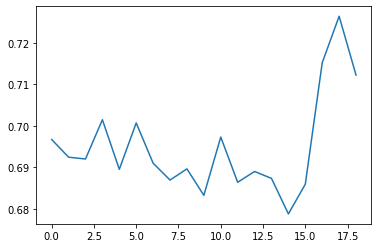

Loss Mean and Std Dev 0.6948511 0.011683054
Epoch: 001, Train Acc: 0.5233
LOSS 0.69463056
LOSS 0.6979232
LOSS 0.6719834
LOSS 0.700174
LOSS 0.7158583
LOSS 0.7073193
LOSS 0.69068474
LOSS 0.70785475
LOSS 0.68757874
LOSS 0.6884134
LOSS 0.6849166
LOSS 0.6976535
LOSS 0.6877029
LOSS 0.68511236
LOSS 0.69037896
LOSS 0.68842745
LOSS 0.68829787
LOSS 0.69121355
LOSS 0.68998957


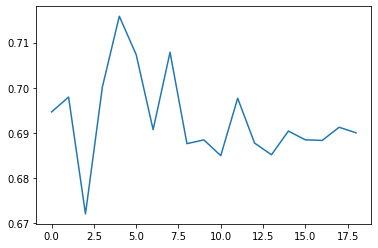

Loss Mean and Std Dev 0.6929533 0.00963389
Epoch: 002, Train Acc: 0.5133


In [74]:
from torch_geometric.loader import DataLoader

train_ds = torch.load('./graph_data_1.pt') 
train_ds = [Data(x=i.x,edge_index=torch.transpose(i.edge_index,0,1).long(),edge_attr=i.edge_attr,y=torch.Tensor([i.y]).long()) for i in train_ds]
train_loader = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
model = GCN(hidden_channels=HIDDEN_LAYERS)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = torch.nn.CrossEntropyLoss()


for epoch in range(1, EPOCHS+1):
    train(model,train_loader,optimizer,criterion)
    train_acc = test(train_loader)
    # test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')



In [75]:
test_ds = torch.load('./graph_data_0.pt')
test_ds = [Data(x=i.x,edge_index=torch.transpose(i.edge_index,0,1).long(),edge_attr=i.edge_attr,y=torch.Tensor([i.y]).long()) for i in test_ds]
test_loader = DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=True)
test_acc = test(test_loader)
print(test_acc)

0.5
